In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

# Para preprocesamiento
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Para modelado
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

# Para evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

print("Entorno configurado correctamente.")




print("✅ Librerías importadas exitosamente")
print("✅ Configuración de visualización establecida")


Entorno configurado correctamente.
✅ Librerías importadas exitosamente
✅ Configuración de visualización establecida


## cargar los datos


In [8]:
# Ruta al archivo CSV con datos de propiedades colombianas
csv_path = "data/properties_gold.csv"

# Cargar dataset completo
df = pd.read_csv(csv_path)
df.head()


,ad_type,start_date,end_date,created_on,lat,lon,price,title,description,property_type,operation_type,surface_total_final,bedrooms_final,bathrooms_final,l3_final,l4_final
0,Propiedad,2020-10-07,2020-10-08,2020-10-07,NaN,NaN,4.000000e+09,Casa en Venta Ubicado en MEDELLIN,Codigo Inmueble 6348 La conocerás y no te quer...,Casa,Venta,NaN,7.0,8.0,Medellín,NaN
1,Propiedad,2020-10-07,9999-12-31,2020-10-07,6.151412,-75.379867,3.800000e+08,Venta de casa en Santa Clara 1 Rionegro,"Rionegro\nUbicación Santa Clara 1\nLote 76, 5 ...",Casa,Venta,NaN,4.0,3.0,Rionegro,NaN
2,Propiedad,2020-10-07,2021-01-19,2020-10-07,6.129877,-75.377835,3.900000e+08,VENTA CASA INDEPENDIENTE EN RIONEGRO ANTIOQUIA,"4 alcobas, 3 baños, estudio, cocina integral, ...",Casa,Venta,NaN,4.0,3.0,Rionegro,NaN
3,Propiedad,2020-10-07,2021-07-23,2020-10-07,6.344035,-75.540817,3.150000e+08,"Casa Unifamiliar En Conjunto, Bello- Niquía",Uno de los sectores de mayor desarrollo comerc...,Casa,Venta,NaN,4.0,1.0,Bello,Niquía
4,Propiedad,2020-10-07,2021-04-21,2020-10-07,6.177846,-75.570831,1.400000e+09,Hermosa casa en venta Envigado Benedictinos,Hermosa casa en con dos niveles y con espectac...,Casa,Venta,NaN,3.0,NaN,Envigado,La Frontera


In [9]:
data = df.dropna(subset=['created_on', 'price', 'surface_total_final', 'bedrooms_final', 'bathrooms_final', 'l3_final', 'l4_final'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21192 entries, 5 to 140434
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_type              21192 non-null  object 
 1   start_date           21192 non-null  object 
 2   end_date             21192 non-null  object 
 3   created_on           21192 non-null  object 
 4   lat                  16543 non-null  float64
 5   lon                  16543 non-null  float64
 6   price                21192 non-null  float64
 7   title                21192 non-null  object 
 8   description          21192 non-null  object 
 9   property_type        21192 non-null  object 
 10  operation_type       21192 non-null  object 
 11  surface_total_final  21192 non-null  float64
 12  bedrooms_final       21192 non-null  float64
 13  bathrooms_final      21192 non-null  float64
 14  l3_final             21192 non-null  object 
 15  l4_final             21192 non-null  obj

In [5]:
# Descripción estadística del dataset
data.describe()




,lat,lon,price,surface_total_final,bedrooms_final,bathrooms_final
count,16543.000000,16543.000000,2.119200e+04,21192.000000,21192.000000,21192.000000
mean,6.234315,-75.581320,5.115676e+08,127.064884,2.738250,2.331587
std,0.051526,0.040168,3.716410e+09,605.307193,1.142176,1.106956
min,5.965000,-76.635333,1.850000e+07,10.000000,0.000000,0.500000
25%,6.202958,-75.601000,2.300000e+08,65.000000,2.000000,2.000000
50%,6.237294,-75.585458,3.300000e+08,86.000000,3.000000,2.000000
75%,6.262000,-75.565000,5.000000e+08,130.000000,3.000000,3.000000
max,7.890249,-74.513000,4.650000e+11,83333.000000,35.000000,19.000000


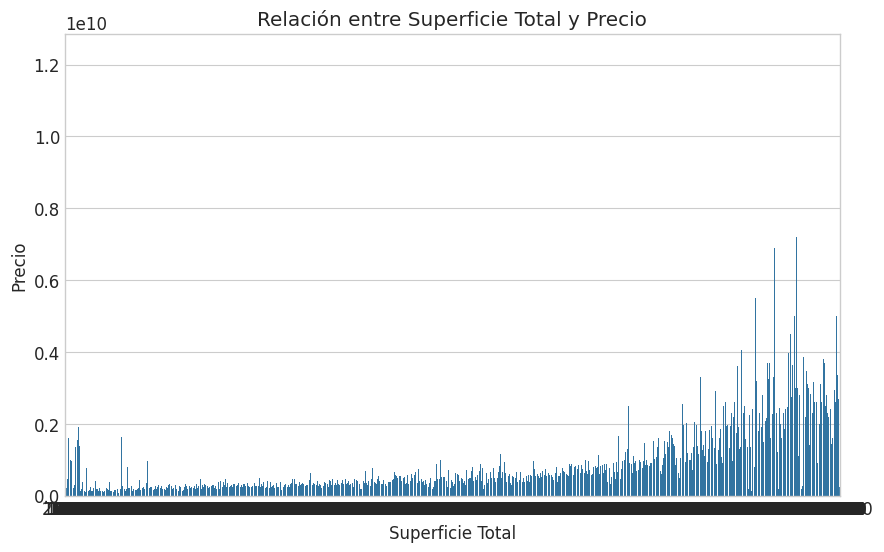

In [ ]:
# Relación entre superficie total y precio
plt.figure(figsize=(10, 6))
sns.barplot(x='surface_total_final', y='price', data=data, ci=None)
plt.title('Relación entre Superficie Total y Precio')
plt.xlabel('Superficie Total')
plt.ylabel('Precio')
plt.savefig('relacion_precio.png', dpi=300, bbox_inches='tight')
    

## Eliminación de outliers

In [10]:
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

# Filtrar datos dentro de 1.5*IQR del rango intercuartílico
data = data[(data['price'] >= Q1 - 1.5 * IQR) & (data['price'] <= Q3 + 1.5 * IQR)]

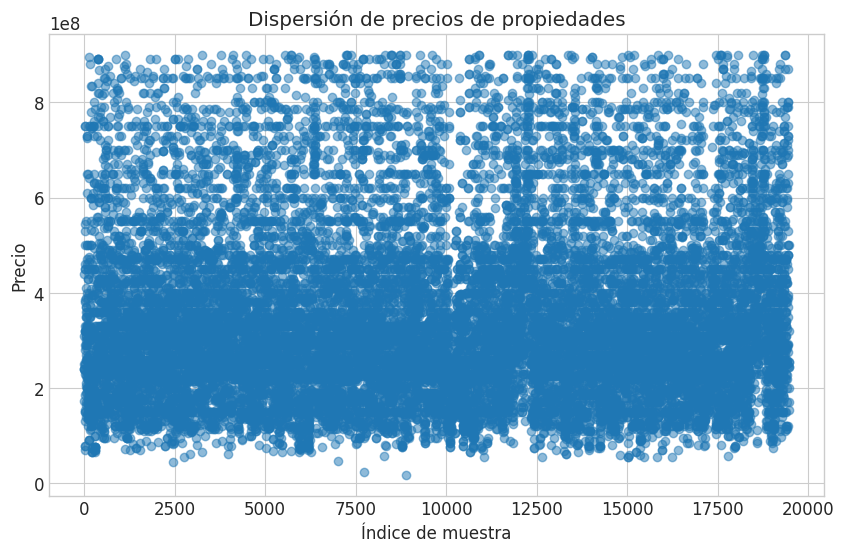

In [11]:
# Gráfico de dispersión de precios",
plt.figure(figsize=(10, 6))
plt.scatter(range(len(data)), data['price'], alpha=0.5)
plt.title('Dispersión de precios de propiedades')
plt.xlabel('Índice de muestra')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

In [12]:
# Seleccionar características relevantes
features = ['created_on', 'surface_total_final', 'bedrooms_final', 'bathrooms_final', 'l3_final', 'l4_final']
X = data[features]
y = data['price']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

# Identificar tipos de columnas
numeric_features = ['surface_total_final', 'bedrooms_final', 'bathrooms_final']
categorical_features = ['l3_final', 'l4_final']

# Crear transformadores para diferentes tipos de columnas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar transformadores usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Verificar la forma de los datos después del preprocesamiento
X_train_preprocessed = preprocessor.fit_transform(X_train)
print(f"Forma de X_train después del preprocesamiento: {X_train_preprocessed.shape}")


Tamaño del conjunto de entrenamiento: 15572 muestras
Tamaño del conjunto de prueba: 3894 muestras
Forma de X_train después del preprocesamiento: (15572, 96)


In [ ]:
models = {
    'Regresión Logística': LogisticRegression(max_iter=100, random_state=42),
    'Árbol de Decisión': DecisionTreeClassifier(random_state=42),
    #'Random Forest': RandomForestClassifier(random_state=42),
    #'SVM': SVC(probability=True, random_state=42)
}

# Crear pipelines para cada modelo
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

# Evaluar modelos con validación cruzada
results = {}
for name, pipeline in pipelines.items():
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    print(f"{name}: Exactitud CV = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Visualizar resultados de validación cruzada
cv_means = [results[name]['cv_mean'] for name in models.keys()]
cv_stds = [results[name]['cv_std'] for name in models.keys()]

plt.figure(figsize=(12, 6))
plt.bar(models.keys(), cv_means, yerr=cv_stds, capsize=10)
plt.title('Comparación de Modelos (Validación Cruzada)')
plt.xlabel('Modelo')
plt.ylabel('Exactitud Media')
plt.ylim([0.7, 0.9])  # Ajustar según los resultados
plt.grid(axis='y')
plt.savefig('Comparacion_modelos_areas_inmuebles.png', dpi=300, bbox_inches='tight')

# Seleccionar el mejor modelo basado en validación cruzada
best_model_name = max(results, key=lambda x: results[x]['cv_mean'])
best_pipeline = pipelines[best_model_name]
print(f"\nMejor modelo: {best_model_name} con exactitud CV de {results[best_model_name]['cv_mean']:.4f}")

# Entrenar el mejor modelo en todo el conjunto de entrenamiento
best_pipeline.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Métricas de rendimiento
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nRendimiento en el conjunto de prueba:")
print(f"Exactitud: {accuracy:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Exhaustividad: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.savefig('titanic_matriz_confusion.png', dpi=300, bbox_inches='tight')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('propiedades_curva_roc.png', dpi=300, bbox_inches='tight')

# Informe de clasificación detallado
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))


In [ ]:
# Definir espacio de búsqueda de hiperparámetros según el mejor modelo
if best_model_name == 'Regresión Logística':
    param_grid = {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'lbfgs'],
        'model__penalty': ['l1', 'l2']
    }
elif best_model_name == 'Árbol de Decisión':
    param_grid = {
        'model__max_depth': [None, 5, 10, 15, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'model__C': [0.1, 1, 10, 100],
        'model__gamma': ['scale', 'auto', 0.1, 0.01],
        'model__kernel': ['rbf', 'linear']
    }

# Realizar búsqueda en cuadrícula
print("\nIniciando optimización de hiperparámetros. Esto puede tomar un tiempo...")
grid_search = GridSearchCV(
    best_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("\nMejores hiperparámetros:")
print(grid_search.best_params_)
print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_:.4f}")

# Evaluar modelo optimizado en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test)
y_pred_proba_optimized = best_model.predict_proba(X_test)[:, 1]

# Métricas de rendimiento del modelo optimizado
accuracy_opt = accuracy_score(y_test, y_pred_optimized)
precision_opt = precision_score(y_test, y_pred_optimized)
recall_opt = recall_score(y_test, y_pred_optimized)
f1_opt = f1_score(y_test, y_pred_optimized)
roc_auc_opt = roc_auc_score(y_test, y_pred_proba_optimized)

print("\nRendimiento del modelo optimizado en el conjunto de prueba:")
print(f"Exactitud: {accuracy_opt:.4f}")
print(f"Precisión: {precision_opt:.4f}")
print(f"Exhaustividad: {recall_opt:.4f}")
print(f"F1-Score: {f1_opt:.4f}")
print(f"AUC-ROC: {roc_auc_opt:.4f}")
